## Algorithms

1.  DBSCAN
2.  K-Means
3.  Gaussian Mixture models
4.  BIRCH

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('data'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

data/Mall_Customers.csv


## Import Libraries

In [2]:
from warnings import filterwarnings
filterwarnings("ignore")

import matplotlib.pyplot as plt 
import seaborn as sns 

from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, DBSCAN, Birch
from sklearn.mixture import GaussianMixture

In [3]:
sns.set_style('darkgrid', {"axes.facecolor": ".85"})
sns.set_context("notebook", font_scale=1.2, rc={"lines.linewidth": 1.2})

## EDA

In [4]:
data = pd.read_csv('data/Mall_Customers.csv')

In [5]:
data.shape

(200, 5)

In [6]:
data.head()

,CustomerID,Gender,Age,Annual Income (k$),Spending Score (1-100)
0,1,Male,19,15,39
1,2,Male,21,15,81
2,3,Female,20,16,6
3,4,Female,23,16,77
4,5,Female,31,17,40


In [7]:
data.isna().sum()

CustomerID                0
Gender                    0
Age                       0
Annual Income (k$)        0
Spending Score (1-100)    0
dtype: int64

In [8]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 5 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   CustomerID              200 non-null    int64 
 1   Gender                  200 non-null    object
 2   Age                     200 non-null    int64 
 3   Annual Income (k$)      200 non-null    int64 
 4   Spending Score (1-100)  200 non-null    int64 
dtypes: int64(4), object(1)
memory usage: 7.9+ KB


In [9]:
data.describe()

,CustomerID,Age,Annual Income (k$),Spending Score (1-100)
count,200.000000,200.000000,200.000000,200.000000
mean,100.500000,38.850000,60.560000,50.200000
std,57.879185,13.969007,26.264721,25.823522
min,1.000000,18.000000,15.000000,1.000000
25%,50.750000,28.750000,41.500000,34.750000
50%,100.500000,36.000000,61.500000,50.000000
75%,150.250000,49.000000,78.000000,73.000000
max,200.000000,70.000000,137.000000,99.000000


## PCA

In [10]:
X = data.drop(['CustomerID', 'Gender'], axis=1)

In [11]:
# PCA for visualization
pca = PCA(n_components = 2)
pca.fit(X)
X_pca = pca.transform(X)

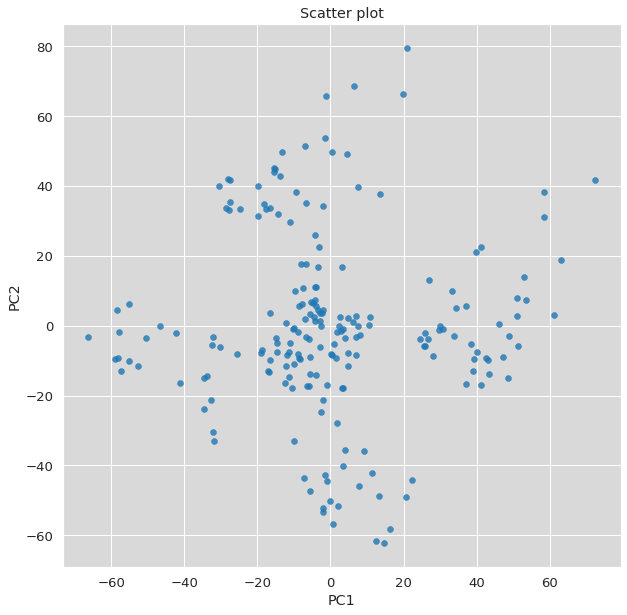

In [12]:
# plot PCA components
fig, axs = plt.subplots(figsize=[10,10])
sns.scatterplot(x=X_pca[:,0],
                y=X_pca[:,1],
                edgecolor=None,
                alpha=0.8,
                ax=axs)
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('Scatter plot')
plt.show()

In [13]:
pca.explained_variance_ratio_

array([0.45125272, 0.44098465])

## Meshgrid points

In [80]:
X1 = X.values
h = 0.1
x_min, x_max = X_pca[:, 0].min() - 1, X_pca[:, 0].max() + 1
y_min, y_max = X_pca[:, 1].min() - 1, X_pca[:, 1].max() + 1
# y_min, y_max = X1[:, 2].min() - 1, X1[:, 2].max() + 1
xx, yy= np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

In [81]:
np.c_[xx.ravel(), yy.ravel()].shape

(2020480, 2)

## Functions

In [91]:
def plot_clusters(model, labels):
    # plot PCA components
    # unique labels
    labels2 = np.unique(labels)
#     print(labels2.shape)
    fig, axs = plt.subplots(figsize=[10,10])
    
    # plot cluster regions
    Z = model.predict(pca.inverse_transform(np.c_[xx.ravel(), yy.ravel()])) 
    Z = Z.reshape(xx.shape)
    plt.imshow(Z , interpolation='nearest', 
               extent=(xx.min(), xx.max(), yy.min(), yy.max()),
               cmap = plt.cm.Pastel2, aspect = 'auto', origin='lower')
    # plot cluster points
    sns.scatterplot(x=X_pca[:,0],
                    y=X_pca[:,1],
                    hue=labels,
                    palette=sns.color_palette('husl', labels2.shape[0]),
                    edgecolor=None,
                    alpha=0.8,
                    s=60,
                    ax=axs)
    plt.xlabel('PC1')
    plt.ylabel('PC2')
    plt.title('Clusters')
        
    plt.show()

## DBSCAN

In [83]:
model = DBSCAN(eps=12, min_samples=3)
labels = model.fit_predict(X)

In [84]:
np.unique(labels)

array([-1,  0,  1,  2,  3,  4,  5])

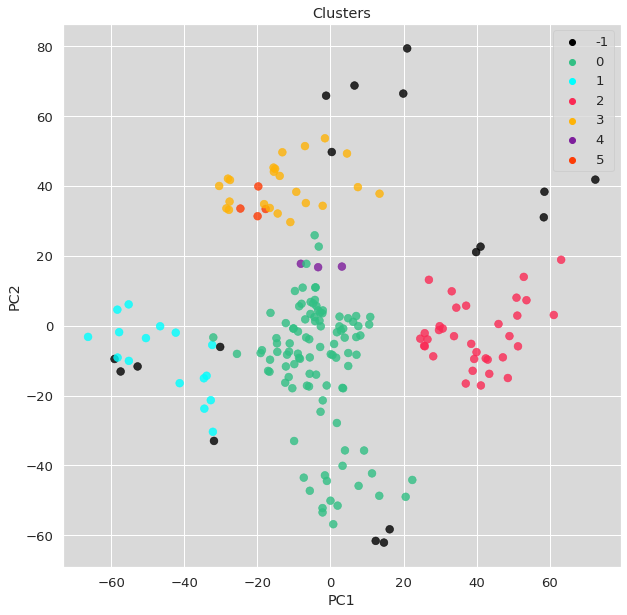

In [86]:
# plot PCA components
fig, axs = plt.subplots(figsize=[10,10])
sns.scatterplot(x=X_pca[:,0],
                y=X_pca[:,1],
                hue=labels,
                palette=sns.xkcd_palette(['black', 'greenish teal', 'cyan', 'red pink', 'amber', 'purple', 'red orange']),
                edgecolor=None,
                alpha=0.8,
                s = 60,
                ax=axs)
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('Clusters')
plt.show()

## K means

In [87]:
inertia = []
for n in range(2 , 11):
    model = KMeans(n_clusters=n, random_state=21, algorithm='elkan')
    model.fit(X)
    inertia.append(model.inertia_)

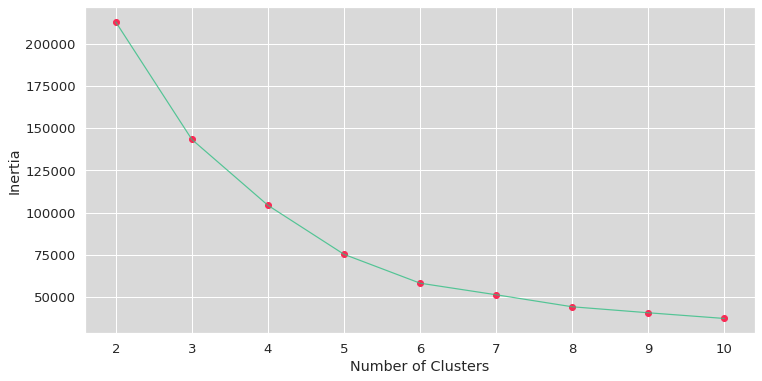

In [88]:
plt.figure(figsize = (12 ,6))
plt.plot(np.arange(2 , 11) , inertia , 'o', c=sns.xkcd_rgb['red pink'])
plt.plot(np.arange(2 , 11) , inertia , '-' ,c=sns.xkcd_rgb['greenish teal'], alpha = 0.8)
plt.xlabel('Number of Clusters') , plt.ylabel('Inertia')
plt.show()

### Five clusters

In [89]:
model = KMeans(n_clusters=5, random_state= 21, algorithm='elkan')
model.fit(X)
labels = model.labels_

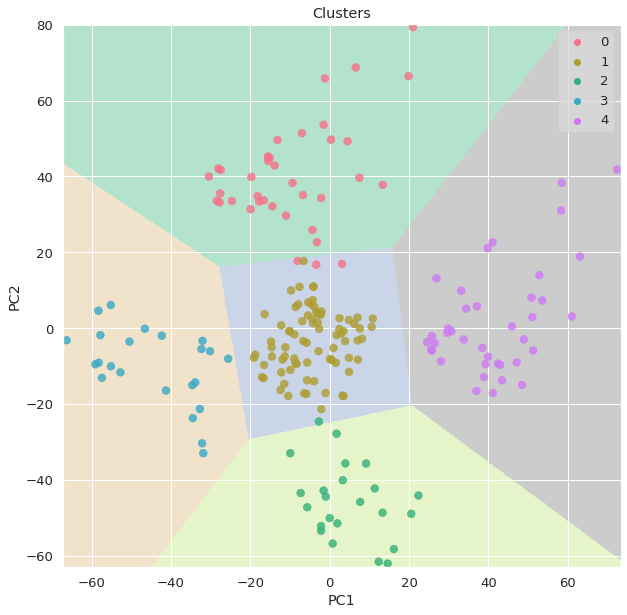

In [92]:
plot_clusters(model, labels)

### Six clusters

In [93]:
model = KMeans(n_clusters=6, random_state= 21, algorithm='elkan')
model.fit(X)
labels = model.labels_

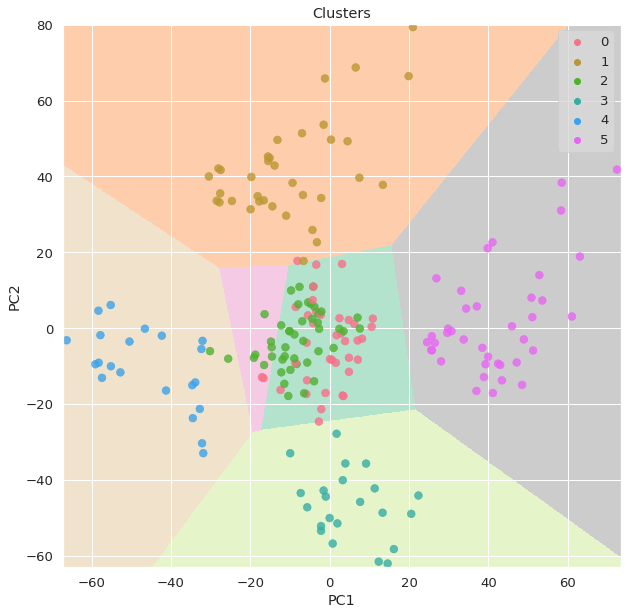

In [94]:
plot_clusters(model, labels)

## Gaussian Mixtures

In [95]:
score = []
ppl = []
aic = []
bic = []
for n in range(2 , 11):
    model = GaussianMixture(n_components=n)
    model.fit(X)
    score.append(silhouette_score(X, model.predict(X)))
    ppl.append(np.exp(model.score(X)))
    aic.append(model.aic(X))
    bic.append(model.bic(X))

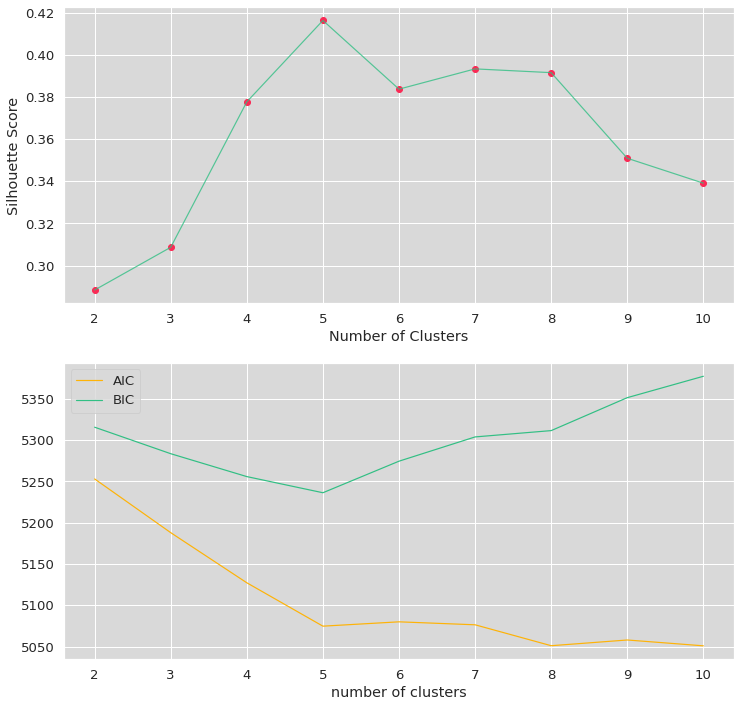

In [96]:
fig, axs = plt.subplots(2,1, figsize = (12 ,12))

## plot silhouette score
axs[0].plot(np.arange(2 , 11) , score , 'o', c=sns.xkcd_rgb['red pink'])
axs[0].plot(np.arange(2 , 11) , score , '-' ,c=sns.xkcd_rgb['greenish teal'], alpha = 0.8)
axs[0].set_xlabel('Number of Clusters') , axs[0].set_ylabel('Silhouette Score')
# axs[0].set_title('Silhouette Score')

## plot aic and bic
axs[1].plot(np.arange(2 , 11) , aic , '-', c=sns.xkcd_rgb['amber'], label='AIC')
axs[1].plot(np.arange(2 , 11) , bic , '-' ,c=sns.xkcd_rgb['greenish teal'], label='BIC')
axs[1].set_ylabel('')
axs[1].set_xlabel('number of clusters')
axs[1].legend(loc='best')


## plot perplexcity
# axs[2].plot(np.arange(2 , 11) , ppl , '-' ,c=sns.xkcd_rgb['greenish teal'])
# axs[2].set_ylabel('perplexity')
# axs[2].set_xlabel('number of clusters')

plt.show()

### Five clusters

In [97]:
model = GaussianMixture(n_components=5)
model.fit(X)
labels = model.predict(X)

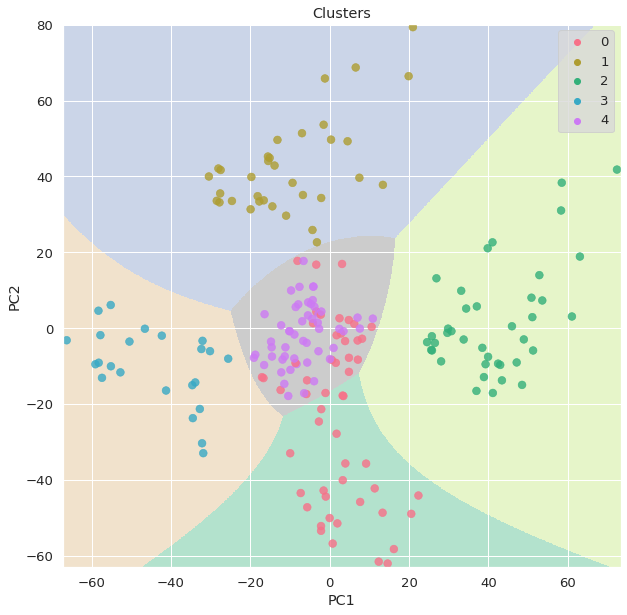

In [98]:
plot_clusters(model, labels)

In [99]:
# Print Silhouette score for five clusters
silhouette_score(X, model.predict(X))

0.4162356745989718

### Six Clusters

In [100]:
model = GaussianMixture(n_components=6)
model.fit(X)
labels = model.predict(X)

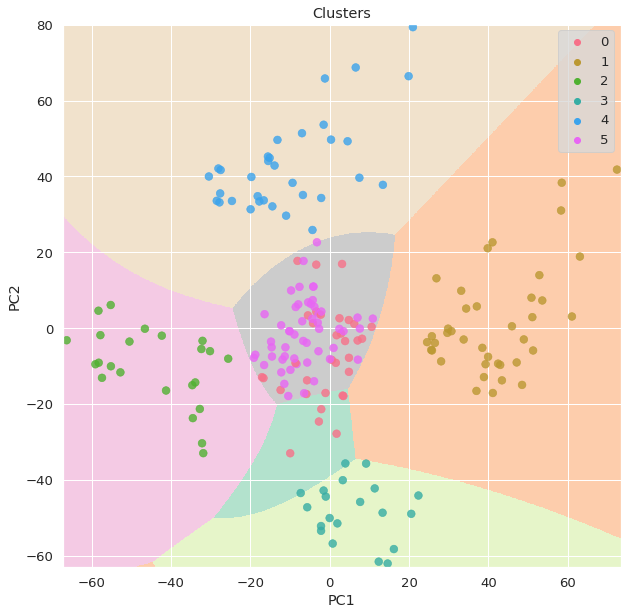

In [101]:
plot_clusters(model, labels)

In [102]:
# Print Silhouette score for six clusters
silhouette_score(X, model.predict(X))

0.4458378313266269

## Birch

In [103]:
model = Birch(n_clusters=5)
model.fit(X)
labels = model.predict(X)

In [104]:
np.unique(labels)

array([0, 1, 2, 3, 4])

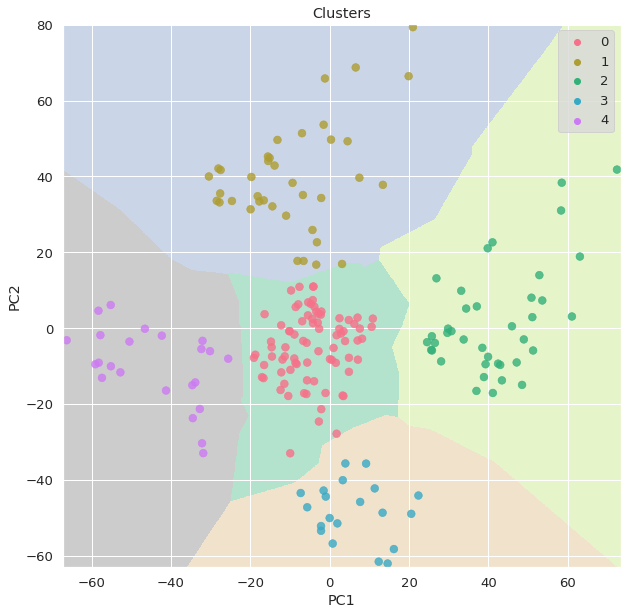

In [105]:
plot_clusters(model, labels)

## References

*  https://www.mygreatlearning.com/blog/dbscan-algorithm/
*  https://blog.floydhub.com/introduction-to-k-means-clustering-in-python-with-scikit-learn/
*  https://www.analyticsvidhya.com/blog/2019/10/gaussian-mixture-models-clustering/
*  https://jakevdp.github.io/PythonDataScienceHandbook/05.12-gaussian-mixtures.html
*  https://dl.acm.org/doi/10.1145/235968.233324
*  https://machinelearningmastery.com/clustering-algorithms-with-python/